# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

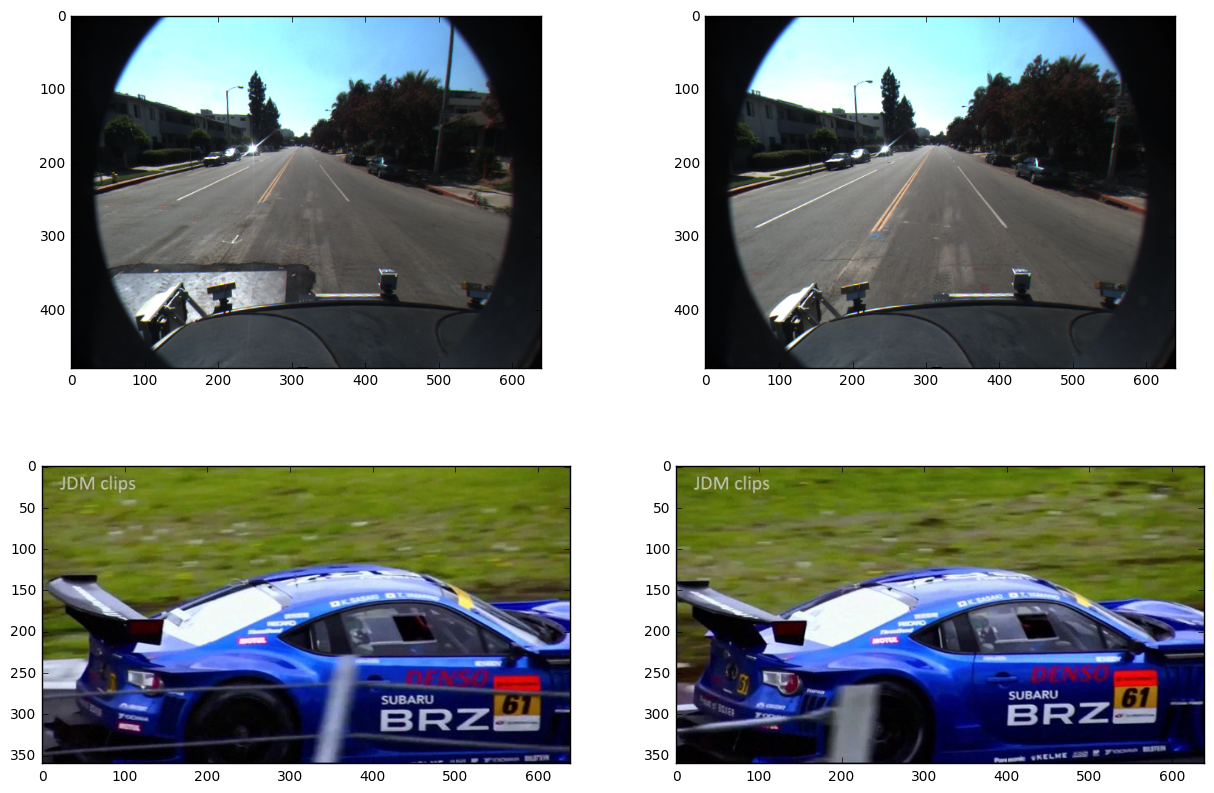

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from skimage import io, data, feature, color
import numpy as np
import operator

# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(car1)
ax22.imshow(car2)

### Wir implementieren den Algorithmus aus der Vorlesung nach

In [3]:
THRESHOLD = 100
def SSD(img1, img2, i , j, x, y):
    if img1.shape == img2.shape:
        
        score = np.sum((img1 - img2)*(img1 - img2))
        return score
    else:
        return np.inf

def getSubImage(image, x, y, search_size):
    return image[y:y+search_size, x:x+search_size]

def find_motion(template, x, y, next_image, search_size):
    # returns upper left corner of the best match
    
    best_i = 0
    best_j = 0
    best_score = np.inf # we want to find a minimum.
    
    for i in range(x - THRESHOLD, x + THRESHOLD, int(search_size/2)) :
        for j in range(y - THRESHOLD, y + THRESHOLD, int(search_size/2)):

            if i >= 0 and i+search_size < next_image.shape[1] and j >= 0 and j+search_size < next_image.shape[0]:
            
                score = SSD(template, getSubImage(next_image, i, j, search_size), i, j, x, y) # maximize correlation
                
                if score < best_score:

                    best_score = score
                    best_i = i
                    best_j = j
                    
    return best_i, best_j

def block_matching(image, next_image, search_size):
    correspondances = []
    for x in range(0,image.shape[1], search_size):
        for y in range(0, image.shape[0], search_size):
            
            template = getSubImage(image, x, y, search_size)
            u, v = find_motion(template, x, y, next_image, search_size)
            correspondances.append([(x,y),(u,v)])
            
    return correspondances   

In [4]:
b = block_matching(car1, car2, 20)

### Wir brauchen auch eine Funktion, die die Pfeile zeigt

In [5]:
def draw_arrows(correspondances, nrOfArrows, image, axis):
    #fig = plt.figure(figsize=(10, 5))
    index = 1
    #currentAxis = plt.gca()
    for i in range(nrOfArrows):
        if i%20 == 0:
            x1 = correspondances[i][0][0]
            y1 = correspondances[i][0][1]
            x2 = correspondances[i][1][0]
            y2 = correspondances[i][1][1]
            dx = x2-x1
            dy = y2-y1
            axis.add_patch(
            patches.Arrow(x1, y1, dx, dy, width=30.0, color='red')
            )
    
    axis.imshow(image)

### Die Pfeile, die auf dem Rasen liegen sind mehr oder weniger willkürlich, das war zu erwarten, die Pfeile, die auf dem Auto liegen erkennen allerdings, dass das Auto vom ersten zum zweiten Bild weitergefahren ist. Es ist im zweiten weiter hinten im Bild, daher die Pfeilrichtungen

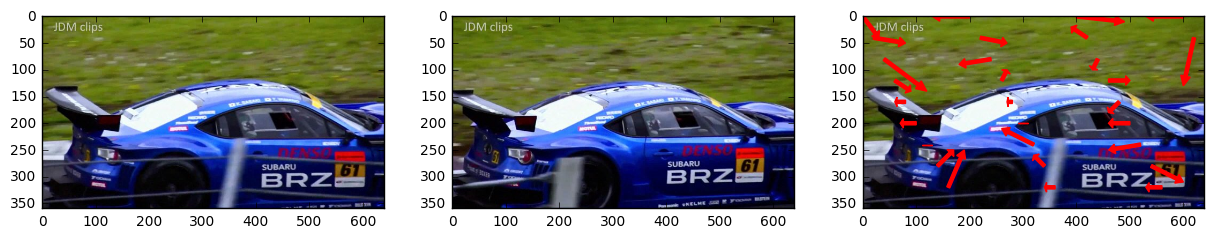

In [6]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
# ...

ax1.imshow(car1)
ax2.imshow(car2)
draw_arrows(b, len(b), car1, ax3)

### Ein zweites Beispiel

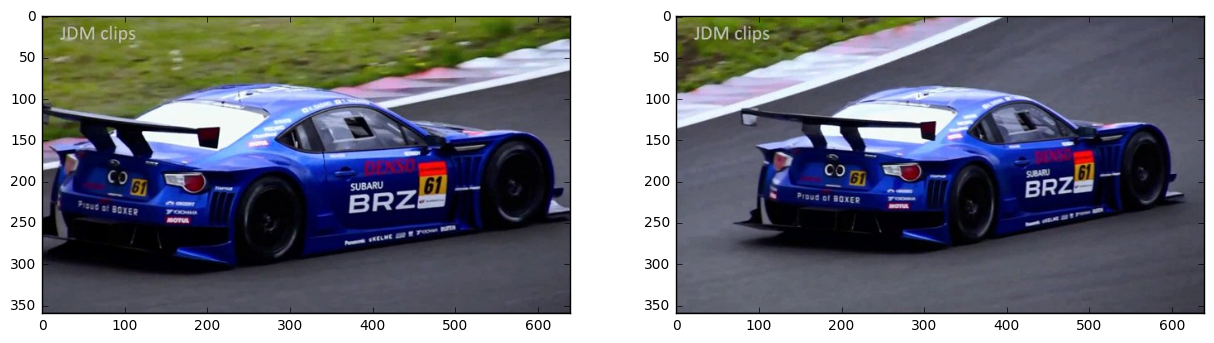

In [7]:
car3 = io.imread('images/racecar/110.jpeg')
car4 = io.imread('images/racecar/115.jpeg')
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(car3)
ax2.imshow(car4)

In [8]:
c = block_matching(car3, car4, 20)

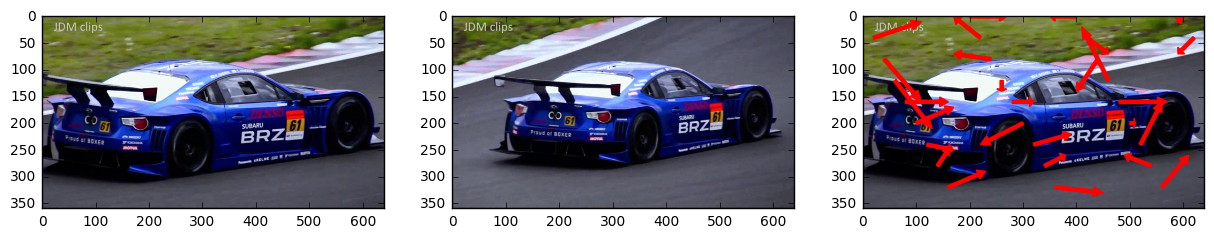

In [9]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
# ...

ax1.imshow(car3)
ax2.imshow(car4)
draw_arrows(c, len(c), car3, ax3)

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [10]:
from scipy.ndimage.filters import sobel
import cv2

In [11]:
def harris_corners(img, window_size, k, thresh):

    # Gradienten über Bild
    dx = sobel(img, axis=0, mode='constant') # np.gradient?!
    dy = sobel(img, axis=1, mode='constant')
    
    # Produkte der Gradienten
    Ixx = dx*dx # broadcast
    Ixy = dy*dx
    Iyy = dy*dy
    
    newImg = img.copy()
    color_img = img

    
    height = img.shape[0]
    width = img.shape[1]
    print(height, width)

    corners = []

    offset = window_size//2

    # 
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            #print(det, trace, r)

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
                #color_img.itemset((y, x, 0), 0)
                #color_img.itemset((y, x, 1), 0)
                #color_img.itemset((y, x, 2), 255)
                corners.append([x, y, r])

    return corners#, color_img


In [12]:
grey_car1 = color.rgb2gray(car1)
grey_car2 =  color.rgb2gray(car2)

In [13]:
corners = harris_corners(grey_car1, 20, 0.04, 10000)

360 640


In [14]:
corners.sort(key=operator.itemgetter(2))

In [91]:
short_c = corners[0:100]

### Wir plotten die besten 100 Ecken, die interessanterweise vielfach auf der Schrift liegen

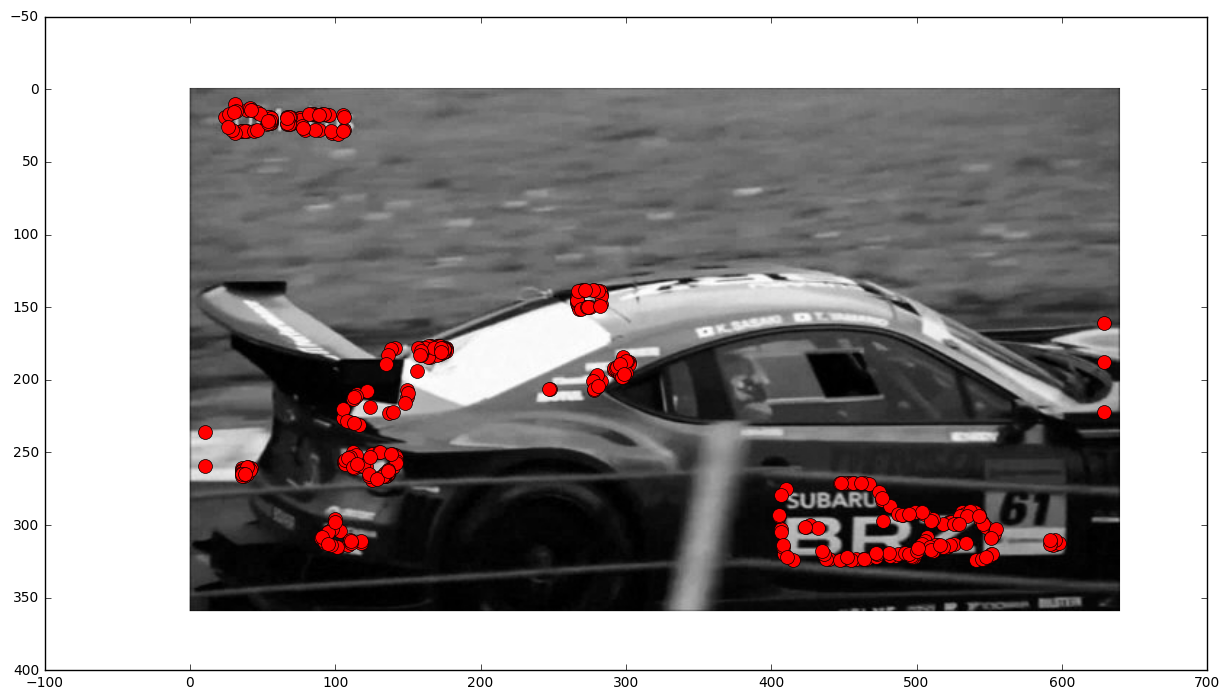

In [16]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.imshow(grey_car1, cmap="gray")
for i in range(len(short_c)):
    ax1.plot(short_c[i][0],short_c[i][1],'ro', linewidth=2, markersize=10)

### Bringe die Ecken in ein Format, sodass Lukas-Canade es benutzen kann

In [94]:
p = np.array(short_c)[:,:2]
p = p.reshape((100,1,2))
p = p.astype(np.float32)

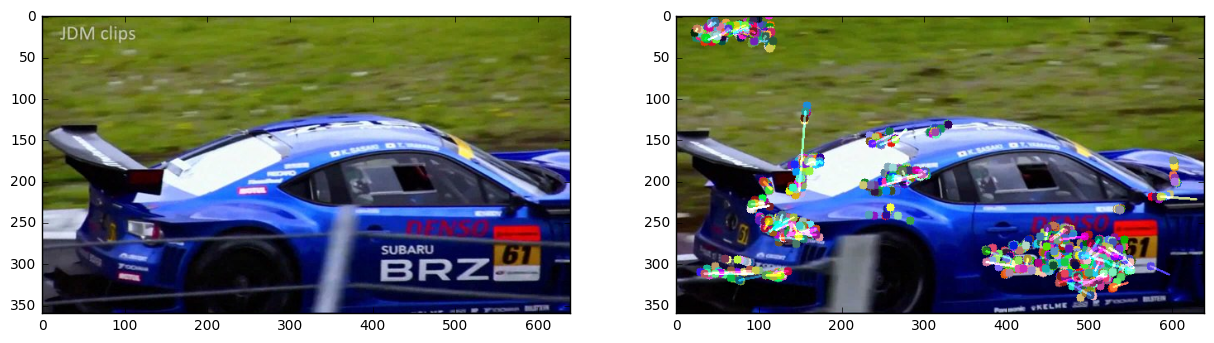

In [103]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
old_gray = cv2.cvtColor(car1, cv2.COLOR_BGR2GRAY)
#old_gray = grey_car1
p0 = p#cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
#print(p0)
#print(p0.shape)

# Create a mask image for drawing purposes
mask = np.zeros_like(car1)

frame = car2
frame_gray = cv2.cvtColor(car2, cv2.COLOR_BGR2GRAY)
# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
# Select good points
good_new = p1[st==1]
good_old = p0[st==1]
# draw the tracks
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
    frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
img = cv2.add(frame,mask)
ax1.imshow(car1)
ax2.imshow(img)
k = cv2.waitKey(30) & 0xff

# Now update the previous frame and previous points
old_gray = frame_gray.copy()
p0 = good_new.reshape(-1,1,2)
#cv2.destroyAllWindows()


Die Optical Flows werden auf dem zweiten Bild angezeigt.